In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa
from scipy.interpolate import interp1d

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32),
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [ ]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [ ]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

In [ ]:
# take the first batch of the training set
batch = next(iter(train_ds))

In [ ]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [ ]:
from tensorflow.keras import layers, models

# Build the CNN model
model_url = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # Assuming 10 classes in EuroSAT dataset
])

In [ ]:
# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [ ]:
m=model_url
# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)])

In [27]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [28]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [29]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples*0.8) // batch_size
# number of validation steps
n_validation_steps = int(num_examples*0.6) // batch_size

In [30]:
# train the model
history = m.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=20,
    callbacks=[model_checkpoint]
)

Epoch 1/20
335/337 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8689 - f1_score: 0.8656
Epoch 1: val_loss improved from inf to 0.57322, saving model to results/satellite-classification.h5
337/337 [==============================] - 5s 15ms/step - loss: 0.3720 - accuracy: 0.8691 - f1_score: 0.8658 - val_loss: 0.5732 - val_accuracy: 0.8307 - val_f1_score: 0.8255
Epoch 2/20
 11/337 [..............................] - ETA: 3s - loss: 0.2495 - accuracy: 0.9176 - f1_score: 0.9128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/337 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.9022 - f1_score: 0.9002
Epoch 2: val_loss improved from 0.57322 to 0.49761, saving model to results/satellite-classification.h5
337/337 [==============================] - 7s 22ms/step - loss: 0.2829 - accuracy: 0.9023 - f1_score: 0.9002 - val_loss: 0.4976 - val_accuracy: 0.8583 - val_f1_score: 0.8528
Epoch 3/20
334/337 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9308 - f1_score: 0.9295
Epoch 3: val_loss did not improve from 0.49761
337/337 [==============================] - 7s 20ms/step - loss: 0.2022 - accuracy: 0.9308 - f1_score: 0.9295 - val_loss: 0.5719 - val_accuracy: 0.8503 - val_f1_score: 0.8457
Epoch 4/20
333/337 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9306 - f1_score: 0.9291
Epoch 4: val_loss did not improve from 0.49761
337/337 [==============================] - 7s 20ms/step - loss: 0.2005 - accuracy: 0.9305 - f1_score: 0.9290 - val_loss:

In [31]:
# load the best weights
m.load_weights(model_path)

In [32]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

images.shape: (5400, 64, 64, 3)
labels.shape: (5400,)


In [33]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

169/169 [==============================] - 0s 2ms/step
predictions.shape: (5400,)


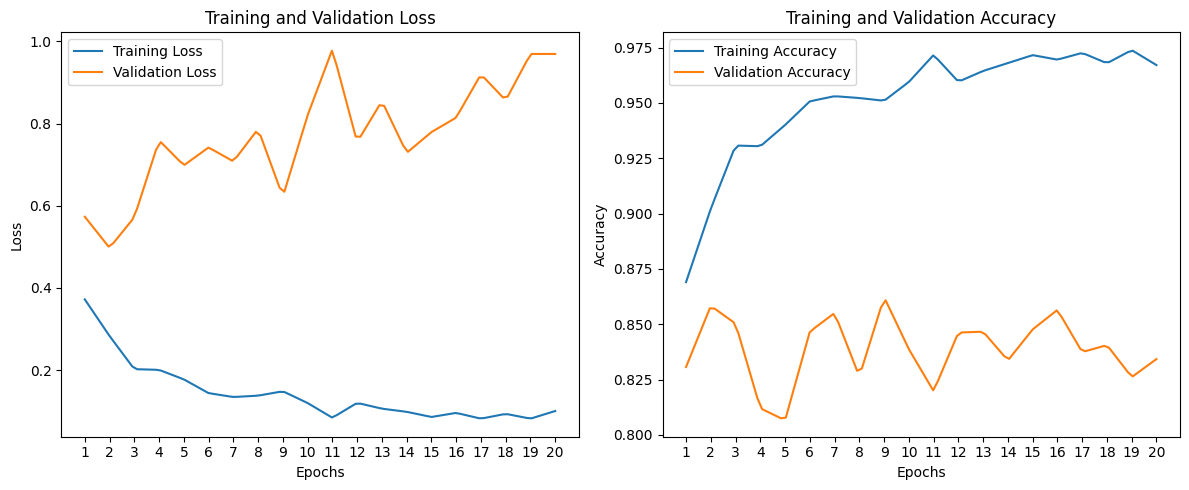

In [34]:
# Extracting training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Interpolating data for smoother curves
epochs = range(1, len(train_loss) + 1)
epochs_smooth = np.linspace(1, len(train_loss), 100)

loss_smooth = interp1d(epochs, train_loss, kind='linear')(epochs_smooth)
val_loss_smooth = interp1d(epochs, val_loss, kind='linear')(epochs_smooth)
accuracy_smooth = interp1d(epochs, train_accuracy, kind='linear')(epochs_smooth)
val_accuracy_smooth = interp1d(epochs, val_accuracy, kind='linear')(epochs_smooth)

# Plotting the graphs
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_smooth, loss_smooth, label='Training Loss')
plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(train_loss) + 1, 1))
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_smooth, accuracy_smooth, label='Training Accuracy')
plt.plot(epochs_smooth, val_accuracy_smooth, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(train_loss) + 1, 1))
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.84166664
F1 Score: 0.836275056006883


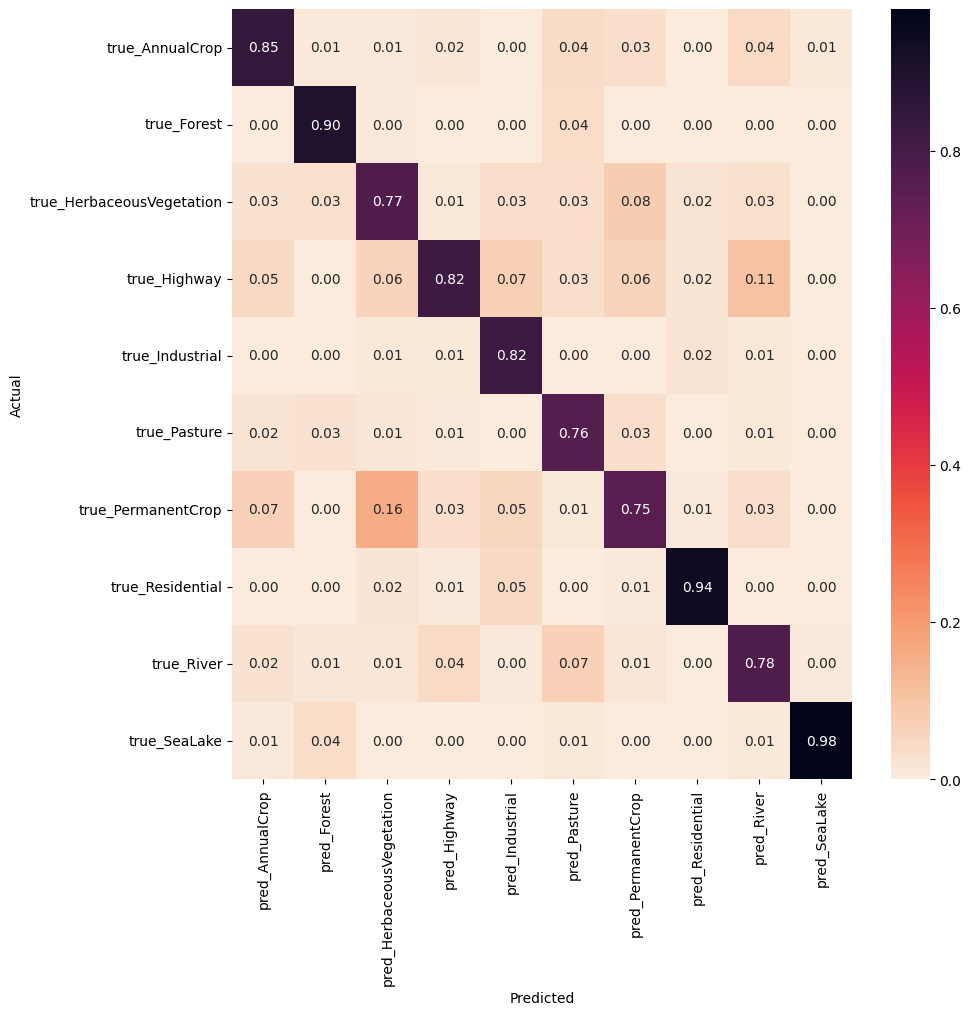

In [36]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r")

plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

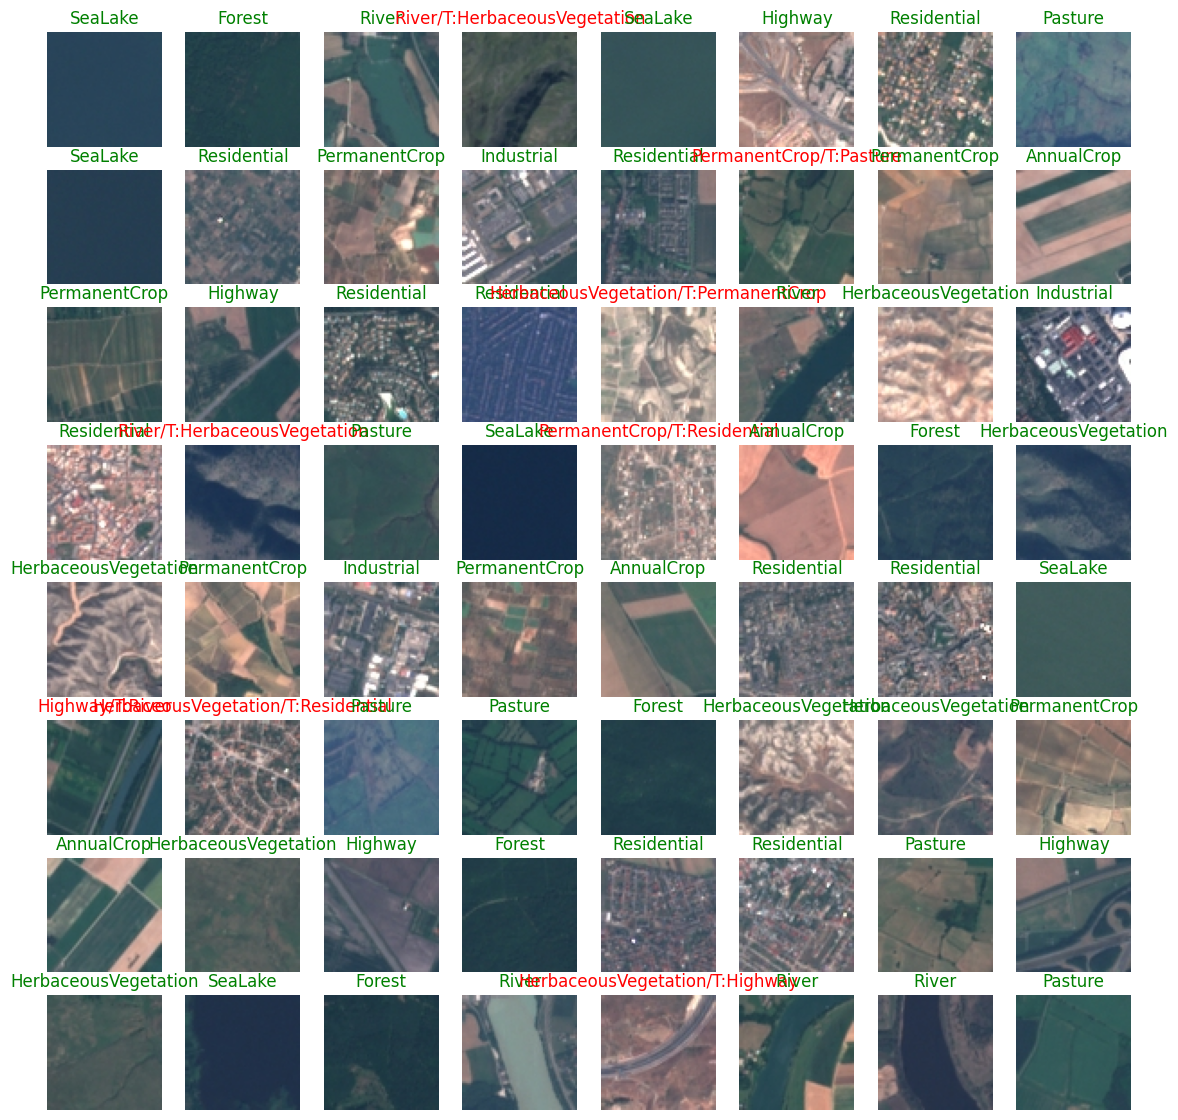

In [37]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')

# showing a batch of images along with predictions labels
show_predicted_samples()